# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime
import timeit
import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import CountVectorizer, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Udacity_DSND_Capstone_Sparkify_project") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'd67720d86921'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Udacity_DSND_Capstone_Sparkify_project'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '46579'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1601562773562')]

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
user_df = spark.read.json("mini_sparkify_event_data.json")
user_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
user_df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [8]:
user_df.count()

286500

In [9]:
#users with blank user id
blank_ids = user_df.filter(user_df.userId == '').select(col('page').alias('blank_pages')).dropDuplicates().show()

+-------------------+
|        blank_pages|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [10]:
#dropping NA vales from user id and session id , dropping empty values from the user id 
df_updated = user_df.dropna(how = "any", subset = ["userId", "sessionId"]).dropDuplicates()
df_updated = df_updated.filter(df_updated["userId"] != "")

In [11]:
#number of rows and columns
df_up = df_updated.toPandas()
df_up.shape

(278154, 18)

In [12]:
# Converting to pandas dataframe
df_updated.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,The Futureheads,Logged In,Ainsley,F,80,Farley,120.81587,free,"McAllen-Edinburg-Mission, TX",PUT,NextSong,1538304455000,187,Robot,200,1538373133000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",78
1,None,Logged In,Ainsley,F,81,Farley,NaN,free,"McAllen-Edinburg-Mission, TX",PUT,Thumbs Down,1538304455000,187,None,307,1538373134000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",78
2,O'Rosko Raricim,Logged In,Madison,F,74,Morales,90.56608,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1536287099000,222,Terre Promise,200,1538384924000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",25
3,Morgan Page,Logged In,Panav,M,23,Myers,235.54567,paid,"Morgantown, WV",PUT,NextSong,1538239045000,237,Strange Condition,200,1538394878000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",15
4,None,Logged In,Ethan,M,15,Raymond,NaN,free,"Hartford-West Hartford-East Hartford, CT",GET,Home,1534245996000,26,None,200,1538402423000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",27


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
#function for cancellation confirmation, i/p 1 if canclled
cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# window partitioned by user in order to input 1 to churn users
window_value = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

#Creating column Churn
df_cncl_Churn = df_updated.withColumn("Churn", cancel_event("page"))
df_cncl_Churn = df_cncl_Churn.withColumn("Churn", Fsum("Churn").over(window_value))

#converting to pandas df and showing some data
df_cncl_Churn.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Bebe,Logged In,Darianna,F,1,Carpenter,225.77587,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,174,Men SeÃÂ±arÃÂ¡,200,1541731859000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,The Ruts,Logged In,Darianna,F,44,Carpenter,338.96444,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,118,West One (Shine On Me),200,1540052737000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,None,Logged In,Darianna,F,21,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Logout,1538016340000,133,None,307,1541415422000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,Shakira,Logged In,Darianna,F,51,Carpenter,363.38893,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,133,Octavo DÃÂ­a,200,1541419901000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,None,Logged In,Darianna,F,100,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,Roll Advert,1538016340000,174,None,200,1541749370000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


In [14]:
#updating registration and timestamp by creating new columns
updated_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_cncl_Churn = df_cncl_Churn.withColumn("new_ts", updated_ts(df_cncl_Churn.ts))
df_cncl_Churn = df_cncl_Churn.withColumn("new_registration", updated_ts(df_cncl_Churn.registration))

#view the changes
df_cncl_Churn.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,Churn,new_ts,new_registration
0,Bebe,Logged In,Darianna,F,1,Carpenter,225.77587,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,174,Men SeÃÂ±arÃÂ¡,200,1541731859000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-11-09 02:50:59,2018-09-27 02:45:40
1,The Ruts,Logged In,Darianna,F,44,Carpenter,338.96444,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,118,West One (Shine On Me),200,1540052737000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-10-20 16:25:37,2018-09-27 02:45:40
2,None,Logged In,Darianna,F,21,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,133,None,307,1541415422000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-11-05 10:57:02,2018-09-27 02:45:40
3,Shakira,Logged In,Darianna,F,51,Carpenter,363.38893,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,133,Octavo DÃÂ­a,200,1541419901000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-11-05 12:11:41,2018-09-27 02:45:40
4,None,Logged In,Darianna,F,100,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,...,1538016340000,174,None,200,1541749370000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-11-09 07:42:50,2018-09-27 02:45:40


In [15]:
df_cncl_Churn.dropDuplicates(['userID']).groupby(['gender', 'Churn']).count().show(5)

+------+-----+-----+
|gender|Churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [16]:
df_cncl_Churn.groupby(['userID']).count().show(5)

+------+-----+
|userID|count|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
|   124| 4825|
+------+-----+
only showing top 5 rows



In [17]:
display(df_cncl_Churn.dtypes)

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('Churn', 'bigint'),
 ('new_ts', 'string'),
 ('new_registration', 'string')]

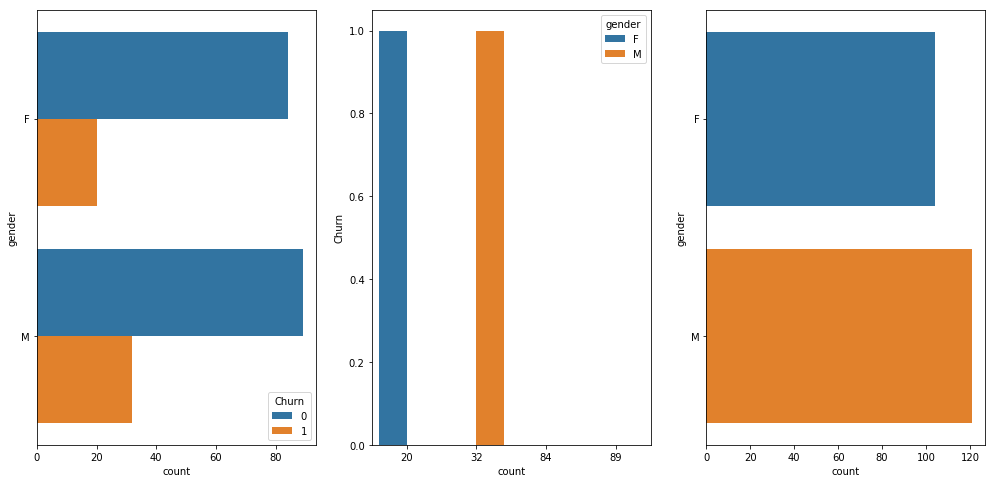

In [18]:
# Genderwise churn effect analysis
data=df_cncl_Churn.dropDuplicates(['userID']).groupby(['gender', 'Churn']).count().toPandas()
fig, ax = plt.subplots(1, 3, figsize=(17, 8))

#plot gender vs count
sns.barplot(x='count', y='gender', hue='Churn', data=data,ax=ax[0])

#plot churn vs count
sns.barplot(x='count', y='Churn', hue='gender', data=data,ax=ax[1])

#plot gender vs count
sns.barplot(x='count', y='gender', data=data.groupby('gender',as_index=False).sum(),ax=ax[2])

by looking in above plots, we could find that male users tends to churn more then females.

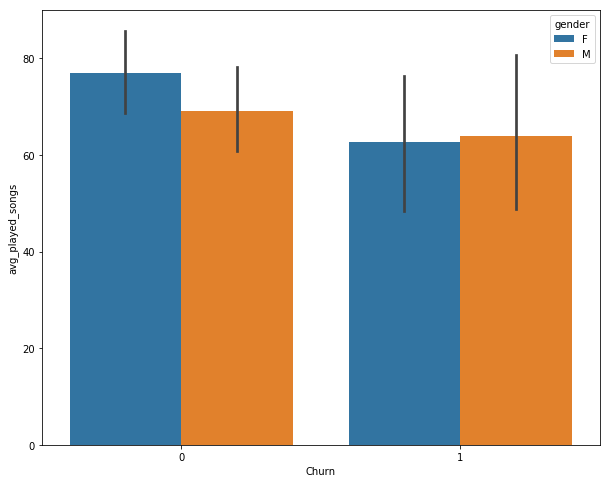

In [19]:
# plotting the distribution for number of songs played per session for churned and normal users
songs_played_df = df_cncl_Churn.where('page == "NextSong"').groupby(['Churn', 'userId', 'sessionId', 'gender']).count()\
                                .groupby(['Churn', 'userId', 'gender']).agg({'count': 'avg'})\
                                .withColumnRenamed('avg(count)', 'avg_played_songs').toPandas()

#plotting the Avg_songs_played by users
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot( x="Churn",y="avg_played_songs", hue="gender", data=songs_played_df,ax=ax);

here we could see the churned users played less number of songs per session compared to users who din't churn out. So its turning out that the male users who listened less number of songs compared to thier female counterparts. 

In [20]:
df_cncl_Churn.select(['sessionId','page','new_ts',"userId"]).filter(df_cncl_Churn.sessionId==1).orderBy('new_ts').dropDuplicates(['userID'])

DataFrame[sessionId: bigint, page: string, new_ts: string, userId: string]

In [21]:
#check the shape of df
df_check2 = df_cncl_Churn.toPandas()
df_check2.shape

(278154, 21)

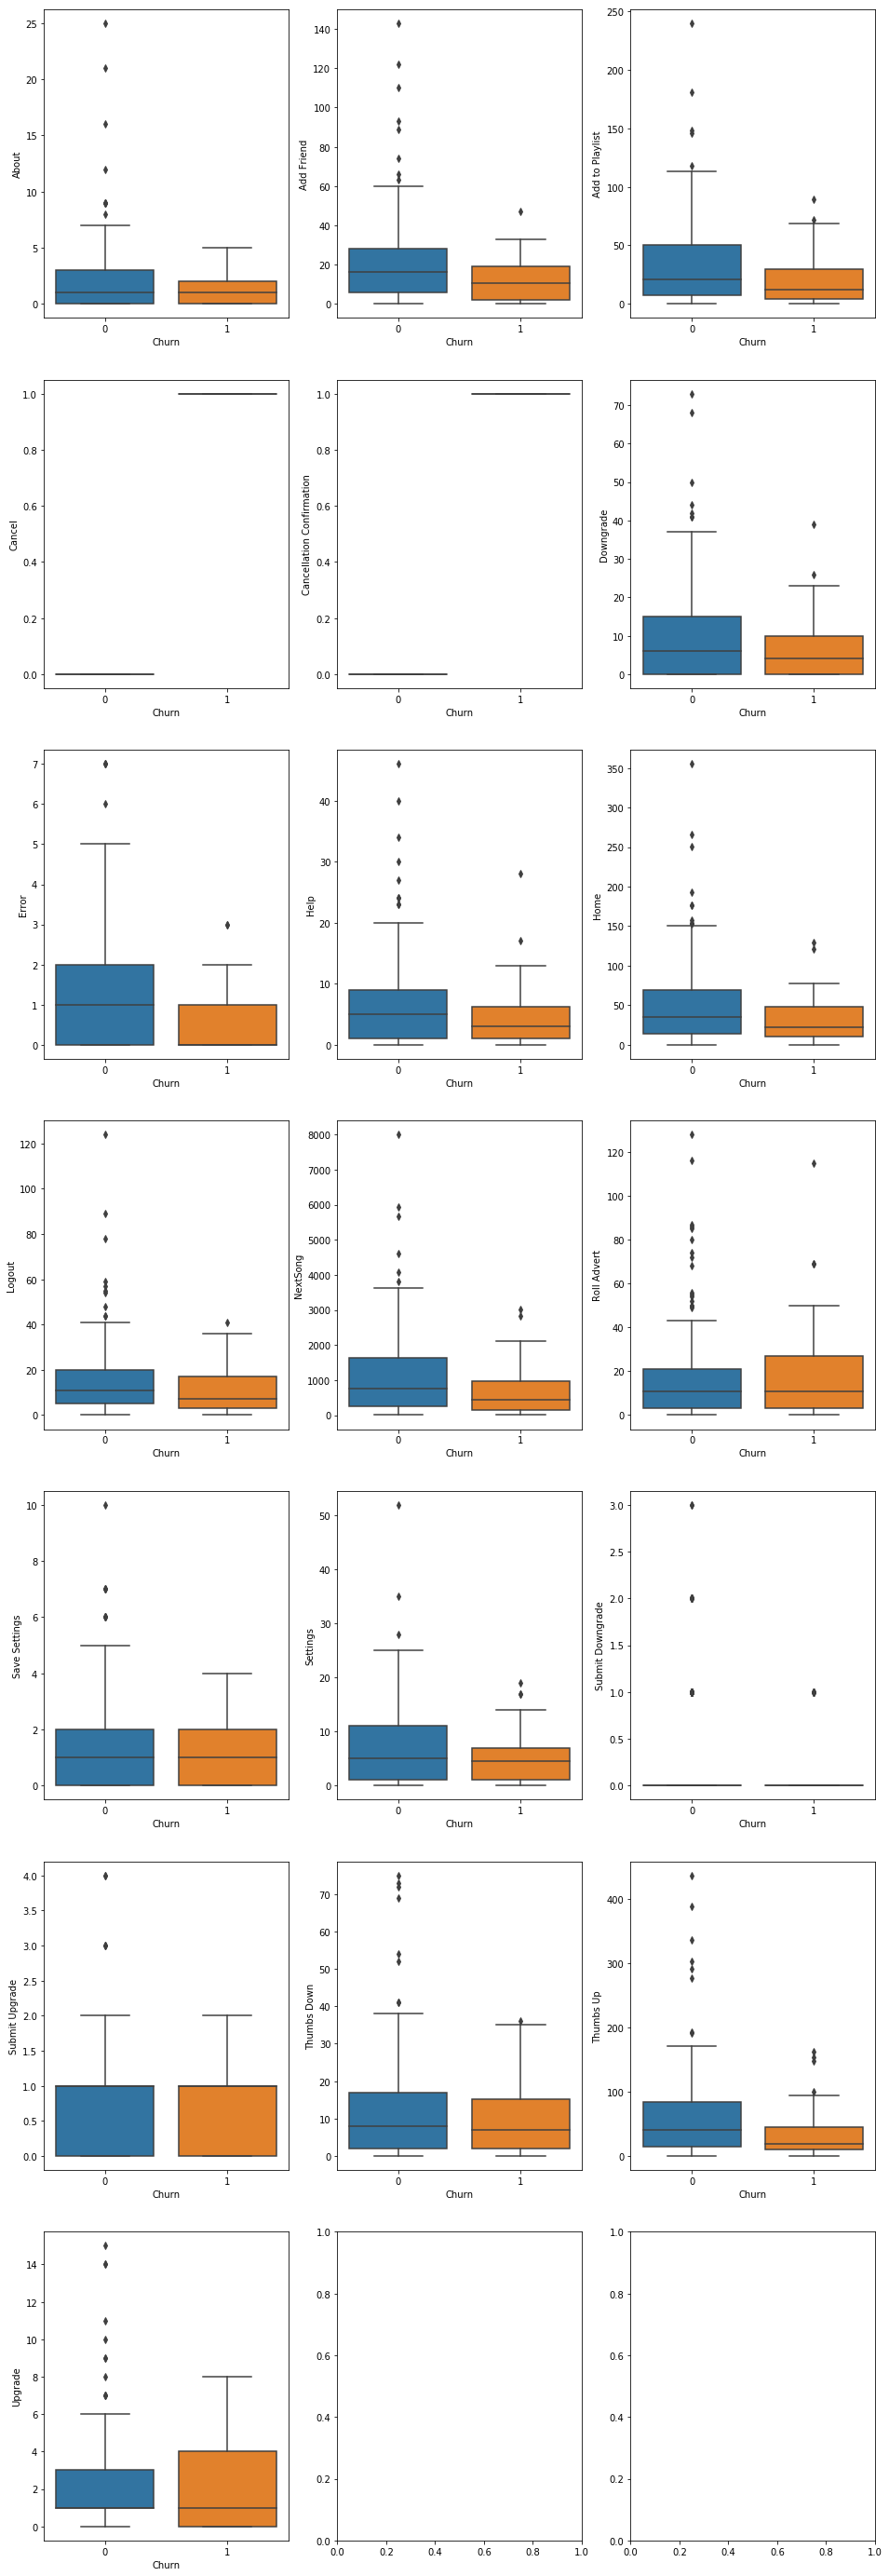

In [22]:
#data frame of the counts per page
plot_var=df_cncl_Churn.groupby(['userId','Churn']).pivot('page').count().toPandas().fillna(value=0)

#list of page to be mapped
columns = list(plot_var.columns)

#removing some unrequired column vars
columns.remove('userId')
columns.remove('Churn')

#plotting histograms
fig, ax = plt.subplots(7, 3, figsize=(16, 50))
for var, subplot in zip(columns, ax.flatten()):
    sns.boxplot(x='Churn', y=var, data=plot_var, ax=subplot)

In [23]:
#some other stats
print ('The Stats for Churn value 0 are :')
print(plot_var[plot_var.Churn==0][columns].describe())
print ("\n")

print ('The Stats for Churn value 1 are :')
print(plot_var[plot_var.Churn==1][columns].describe())

The Stats for Churn value 0 are :
            About  Add Friend  Add to Playlist  Cancel  \
count  173.000000  173.000000       173.000000   173.0   
mean     2.537572   21.046243        31.722543     0.0   
std      3.426136   22.286667        35.056821     0.0   
min      0.000000    0.000000         0.000000     0.0   
25%      0.000000    6.000000         7.000000     0.0   
50%      1.000000   16.000000        21.000000     0.0   
75%      3.000000   28.000000        50.000000     0.0   
max     25.000000  143.000000       240.000000     0.0   

       Cancellation Confirmation   Downgrade       Error        Help  \
count                      173.0  173.000000  173.000000  173.000000   
mean                         0.0    9.930636    1.271676    7.023121   
std                          0.0   12.513520    1.585236    7.664441   
min                          0.0    0.000000    0.000000    0.000000   
25%                          0.0    0.000000    0.000000    1.000000   
50%        

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [24]:
#pivot feature : page
df_page = df_cncl_Churn.groupby(['userId','Churn']).pivot('page').count().fillna(value=0)
dropped_col = ["Cancellation Confirmation","cancel"]
df_page = df_page.drop(*dropped_col)
df_page.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Churn: long (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)



In [25]:
#Feature 1 : Unique Artist Count
feat_1 = df_updated.select("userId", "artist").groupby("userId").agg(F.countDistinct("artist").alias("UniqueArtistCount"))

feat_1.show(5)

+------+-----------------+
|userId|UniqueArtistCount|
+------+-----------------+
|100010|              252|
|200002|              339|
|   125|                8|
|   124|             2232|
|    51|             1385|
+------+-----------------+
only showing top 5 rows



In [26]:
#Feature 2 : Gender
feat_2 = df_updated.select("userId", "gender").dropDuplicates()

#flags to gender
gen_call = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
feat_2 = feat_2.withColumn("gender", gen_call("gender"))

feat_2.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
+------+------+
only showing top 5 rows



In [27]:
#Feature 3 : Number of unique songs listened
feat_3 = df_updated.select("userId", "song").groupby("userId").agg(F.countDistinct("song").alias("UniqueSongCount"))

feat_3.show(5)

+------+---------------+
|userId|UniqueSongCount|
+------+---------------+
|100010|            269|
|200002|            378|
|   125|              8|
|    51|           1854|
|   124|           3339|
+------+---------------+
only showing top 5 rows



In [28]:
#Feature 4 : Total number of events
feat_4 = df_updated.groupby(['userID']).count().withColumnRenamed(("count"), ("totalevents"))

feat_4.show(5)

+------+-----------+
|userID|totalevents|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
+------+-----------+
only showing top 5 rows



In [29]:
#Feature 5 : Total time since registration
feat_5 = df_updated.select('userId', 'registration', 'ts').withColumn('tot_lifetime', (df_updated.ts - df_updated.registration))\
    .groupBy('userId').agg({'tot_lifetime' : 'max'})\
    .withColumnRenamed('max(tot_lifetime)', 'tot_lifetime')\
    .select('userId', (col('tot_lifetime')/1000/3600/24).alias('tot_lifetime'))

feat_5.show(5)

+------+------------------+
|userId|      tot_lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
+------+------------------+
only showing top 5 rows



In [30]:
#Feature 6 : Total number of artists the user has listened to
feat_6 = df_updated.filter(df_updated.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "tot_artist_played")

feat_6.show(5)

+------+-----------------+
|userId|tot_artist_played|
+------+-----------------+
|200002|              339|
|100010|              252|
|   125|                8|
|   124|             2232|
|    51|             1385|
+------+-----------------+
only showing top 5 rows



all the above codes can be written as one function; below function performs all the task what we did above. Above code are written the output of their operation.

In [31]:
def feature_eng(df):
    
    """
    Engineering new features from df
    
    input: cleaned data frame
    output: final data frame for modeling
    
    """    
 

    # Adding all the processes done above into a function
    cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    window_value = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    df_cncl_Churn = df.withColumn("label", cancel_event("page"))# we call label instead of churn
    df_cncl_Churn = df_cncl_Churn.withColumn("label", Fsum("label").over(window_value)) 
    
    #feature Page
    df_page=df_cncl_Churn.groupby(['userId','label']).pivot('page').count().fillna(value=0)
    dropped_col = ["Cancellation Confirmation","cancel"]
    df_page = df_page.drop(*dropped_col)
    
    #feature Unique Artist Count
    feat_1=df_updated.select("userId", "artist").groupby("userId").agg(F.countDistinct("artist").alias("UniqueArtistCount"))
    
    #feature Gender
    gen_call = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
    feat_2= df_updated.select("userId", "gender").dropDuplicates()
    feat_2 = feat_2.withColumn("gender", gen_call("gender"))
    
    #feature Number of unique songs
    feat_3 = df_updated.select("userId", "song").groupby("userId").agg(F.countDistinct("song").alias("UniqueSongCount"))
    
    #feature Total number of events
    feat_4 = df_updated.groupby(['userID']).count().withColumnRenamed(("count"), ("totalevents"))
    
    # Feature 6 : Total time since registration
    feat_5 = df_updated.select('userId', 'registration', 'ts').withColumn('tot_lifetime', (df_updated.ts - df_updated.registration))\
            .groupBy('userId').agg({'tot_lifetime' : 'max'})\
            .withColumnRenamed('max(tot_lifetime)', 'tot_lifetime')\
            .select('userId', (col('tot_lifetime')/1000/3600/24).alias('tot_lifetime'))
    
    #Feature 7 : Total number of artists the user has listened to
    feat_6 = df_updated.filter(df_updated.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
             .withColumnRenamed("count", "tot_artist_played")
     
    # Creating a combined dataframe
    df_combined = df_page.join(feat_1, 'userId', 'inner')
    df_combined = df_combined.join(feat_2, 'userId', 'inner')     
    df_combined = df_combined.join(feat_3, 'userId', 'inner')
    df_combined = df_combined.join(feat_4, 'userId', 'inner')
    df_combined = df_combined.join(feat_5, 'userId', 'inner')
    df_combined = df_combined.join(feat_6, 'userId', 'inner')
        
    return df_combined

In [32]:
final_data= feature_eng(df_updated)

In [33]:
final_data.show(5)

+------+-----+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----------------+------+---------------+-----------+------------------+-----------------+
|userId|label|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|UniqueArtistCount|gender|UniqueSongCount|totalevents|      tot_lifetime|tot_artist_played|
+------+-----+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----------------+------+---------------+-----------+------------------+-----------------+
|100010|    0|    1|         4|              7|        0|    0|   2|  11|     5|     275|         52|            0|       0|               0|             0|          5| 

In [34]:
# checking for any null values
columns_del = ['userId', 'label']
df_feature= final_data.toPandas().drop(columns_del, axis=1)
df_feature.isnull().sum()

About                0
Add Friend           0
Add to Playlist      0
Downgrade            0
Error                0
Help                 0
Home                 0
Logout               0
NextSong             0
Roll Advert          0
Save Settings        0
Settings             0
Submit Downgrade     0
Submit Upgrade       0
Thumbs Down          0
Thumbs Up            0
Upgrade              0
UniqueArtistCount    0
gender               0
UniqueSongCount      0
totalevents          0
tot_lifetime         0
tot_artist_played    0
dtype: int64

In [35]:
#vectorizing all features
cols = final_data.columns
cols = [i for i in cols if i not in ('userId', 'label')]

assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
vect_data = assembler.transform(final_data)

vect_data.head(10)

[Row(userId='100010', label=0, About=1, Add Friend=4, Add to Playlist=7, Downgrade=0, Error=0, Help=2, Home=11, Logout=5, NextSong=275, Roll Advert=52, Save Settings=0, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, UniqueArtistCount=252, gender=0, UniqueSongCount=269, totalevents=381, tot_lifetime=55.6436574074074, tot_artist_played=252, NumFeatures=DenseVector([1.0, 4.0, 7.0, 0.0, 0.0, 2.0, 11.0, 5.0, 275.0, 52.0, 0.0, 0.0, 0.0, 0.0, 5.0, 17.0, 2.0, 252.0, 0.0, 269.0, 381.0, 55.6437, 252.0])),
 Row(userId='200002', label=0, About=3, Add Friend=4, Add to Playlist=8, Downgrade=5, Error=0, Help=2, Home=20, Logout=5, NextSong=387, Roll Advert=7, Save Settings=0, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, UniqueArtistCount=339, gender=1, UniqueSongCount=378, totalevents=474, tot_lifetime=70.07462962962963, tot_artist_played=339, NumFeatures=DenseVector([3.0, 4.0, 8.0, 5.0, 0.0, 2.0, 20.0, 5.0, 387.0,

In [36]:
#Standardizing all input features i.e. Scaler all features
scaler = Normalizer(inputCol="NumFeatures", outputCol="features")
scaled_data = scaler.transform(vect_data)

In [37]:
#Now we have our data to train a machine learning model
scaled_data = scaled_data.select(["label","features"])

scaled_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.00153124954460...|
|    0|[0.00345681437224...|
|    1|(23,[8,9,17,18,19...|
|    0|[8.95258757660716...|
|    1|[4.73743274981536...|
|    0|[0.0,0.0027640802...|
|    0|[5.13296134755204...|
|    1|[8.85782332474354...|
|    0|[0.00113860144978...|
|    1|[0.0,0.0102909717...|
|    0|[0.00102002229760...|
|    0|(23,[1,2,5,6,7,8,...|
|    1|[5.43622645237984...|
|    0|[0.00482083964806...|
|    0|[0.00193100231648...|
|    0|[4.21791326520506...|
|    1|[0.00183477244572...|
|    1|[3.36720695497486...|
|    0|[0.00126204119761...|
|    0|[0.00195876817714...|
+-----+--------------------+
only showing top 20 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [38]:
#split the data in train and test data
train, test = scaled_data.randomSplit([0.85, 0.15], seed=42)

In [42]:
#method Random Forest Classifier
rf_method = RandomForestClassifier()

start_time_rf = time.time()
print(start_time_rf)

#training
rf_model = rf_method.fit(train)

#prediction
rf_result = rf_model.transform(test)

print('Total time taken in training and prediction in seconds: ', (time.time() - start_time_rf))

f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(rf_result.select(col('label'), col('prediction')))
accuracy = MulticlassClassificationEvaluator(metricName='accuracy').evaluate(rf_result.select(col('label'), col('prediction')))
    
print("F1 Score for Random Forest Classifier is {}".format(f1))
print("The accuracy for Random Forest Classifier is {}".format(accuracy))

1601564700.749827
Total time taken in training and prediction in seconds:  295.40548968315125
F1 Score for Random Forest Classifier is 0.6435087719298245
The accuracy for Random Forest Classifier is 0.68


In [40]:
#method Logistic Regression
lr_method = LogisticRegression()

start_time_lr = time.time()
print(start_time_lr)

#training
lr_model = lr_method.fit(train)

#prediction
lr_result = lr_model.transform(test)

print('Total time taken in training and prediction in seconds: ', (time.time() - start_time_lr))

f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(lr_result.select(col('label'), col('prediction')))
accuracy = MulticlassClassificationEvaluator(metricName='accuracy').evaluate(lr_result.select(col('label'), col('prediction')))
    
print("F1 Score for Logistic Regression is {}".format(f1))
print("The accuracy for Logistic Regression is {}".format(accuracy))

Total time taken in training and prediction in seconds:  130.5927119255066
F1 Score for Logistic Regression is 0.6743123543123543
The accuracy for Logistic Regression is 0.72


In [43]:
# method Gradient Boosted Trees
gbt_method = GBTClassifier()

start_time_gbt = time.time()
print(start_time_gbt)

#training
gbt_model = gbt_method.fit(train)

#prediction
gbt_result = gbt_model.transform(test)

print('Total time taken in training and prediction in seconds: ', (time.time() - start_time_gbt))

f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(gbt_result.select(col('label'), col('prediction')))
accuracy = MulticlassClassificationEvaluator(metricName='accuracy').evaluate(gbt_result.select(col('label'), col('prediction')))
    
print("F1 Score for Gradient Boosted Trees is {}".format(f1))
print("The accuracy for Gradient Boosted Trees is {}".format(accuracy))

1601566098.7404945
Total time taken in training and prediction in seconds:  449.2180905342102
F1 Score for Gradient Boosted Trees is 0.613056133056133
The accuracy for Gradient Boosted Trees is 0.64


In above results from 3 different methods we could see that the f1-score and accuracy of Logistic Regression method is better compared to other 2. But it took a lot of computation time than others. It will be more if the size of dataset is larger.

Logistic Regression took more computation time compared to others but its accuracy and f1-socre is competitive. So we will proceed with LR and will try to tune this model.


## Tuning

In [51]:
#tuning Logistic regression model
model_lr = LogisticRegression(maxIter=50)
paramGrid = ParamGridBuilder().addGrid(model_lr.elasticNetParam,[0.1, 0.55, 1]).\
                                addGrid(model_lr.regParam,[0.01, 0.05, 0.1]).build()

lr_evals = MulticlassClassificationEvaluator(metricName='f1')

model_lr_output = CrossValidator(estimator=model_lr, estimatorParamMaps=paramGrid, evaluator=lr_evals,
                                 numFolds=3)
#start training time
start = time.time()

#training the model
tuned_LR = model_lr_output.fit(train)

#prediction
final_LR = tuned_LR.transform(test)

#end time
end = time.time()

print('total time in Training and Predicting: ', (end - start))

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LogisticRegression' object has no attribute '_java_obj'


total time in Training and Predicting:  6516.405846834183


In [52]:
#evaluation metrics for tuned Logical regression
eval_metrics_lr = MulticlassClassificationEvaluator(predictionCol = "prediction")

#The metrics for tuned Logistic regression
print("The accuracy for tuned Logistic regression is {}".format(eval_metrics_lr.evaluate(final_LR, 
                                                        {eval_metrics_lr.metricName : "accuracy"})))
print("The F-1 Score for tuned Logistic regression is {}".format(eval_metrics_lr.evaluate(final_LR, 
                                                        {eval_metrics_lr.metricName : "f1"})))

The accuracy for tuned Logistic regression is 0.72
The F-1 Score for tuned Logistic regression is 0.6743123543123543


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [53]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Sparkify.ipynb to html',
 '[NbConvertApp] Writing 548315 bytes to Sparkify.html',
 '[NbConvertApp] Converting notebook Sparkify-zh.ipynb to html',
 '[NbConvertApp] Writing 279513 bytes to Sparkify-zh.html']